# <center> <b>Deep Learning (6G7V0024)</b></center>
## <center><b>Food Image Classification v.1.00</b></center>


<b>Assignment Brief:</b>

The project will require students to research, investigate and apply deep learning techniques to a real-world 
problem. Students are expected to present their findings in a technical report.
The task for this project involves:

* Identifying a suitable deep learning task, such as classification, detection, segmentation, generation, 
etc.
* Selecting an appropriate dataset for the task. 
* Performing data curation, which includes preparing and pre-processing the selected dataset.
* Identifying, choosing, and improving deep learning algorithms that are applicable to the chosen 
dataset. 
* Conducting a series of experiments on your selected data set.
* Analysing and discussing the results obtained from each experiment.
* Summarizing the findings and identifying potential future work that can be conducted in the chosen problem domain.

## <b>1. Importing Relevant Libraries:</b>

In [1]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Ignore UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

#Importing General Libraries:
import os
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Importing PyTorch Libraries:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

# Importing PyTorch Image Libraries:
import torchvision
from torchvision import models
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# Install opendatasets if not already installed, else import the library
try:
    import opendatasets as od
except:
    !pip install opendatasets
    import opendatasets as od
    
# Importing Scikit-Learn Evaluation Libraries:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize


## <b>2. Downloading Dataset:</b>

In [2]:
# Downloading Dataset
od.download('https://www.kaggle.com/datasets/trolukovich/food11-image-dataset') 

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  farrukhnizamarain


Your Kaggle Key:

  ································


Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset


100%|██████████| 1.08G/1.08G [00:07<00:00, 156MB/s] 


## <b>3. Data Augmentation:</b>

In [3]:
# Declaring batch size, image size, mean and std
batch_size = 32
image_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [4]:
# Define the transformations for the training data
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing()
])

# Define the transformations for the validation data
val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Define the transformations for the test data
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [5]:
# Define the training, validation, and test datasets
train_dataset = datasets.ImageFolder("./food11-image-dataset/training", transform=train_transform)
val_dataset = datasets.ImageFolder("./food11-image-dataset/validation", transform=val_transform) # , transform=val_transform
test_dataset = datasets.ImageFolder("./food11-image-dataset/evaluation", transform=test_transform)

# Batch size for training, validation, and testing.
batch_size = 32

# Data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## <b>4. Initial Data Analysis:</b>

Analyzing training set
                 count
Dessert           1500
Dairy product      429
Vegetable-Fruit    709
Soup              1500
Seafood            855
Bread              994
Rice               280
Egg                986
Noodles-Pasta      440
Fried food         848
Meat              1325
             count
count    11.000000
mean    896.909091
std     421.402766
min     280.000000
25%     574.500000
50%     855.000000
75%    1159.500000
max    1500.000000


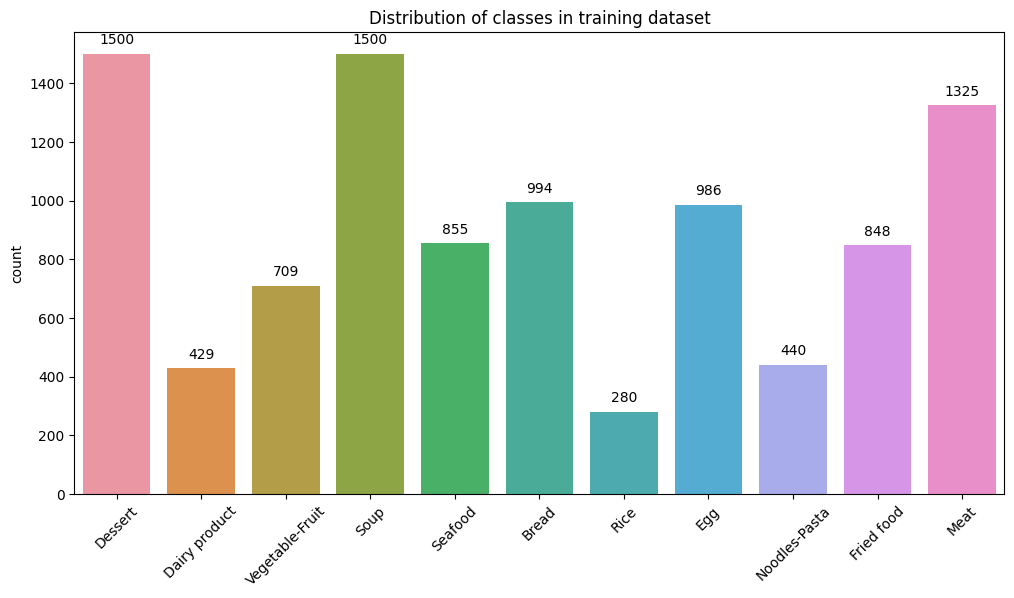

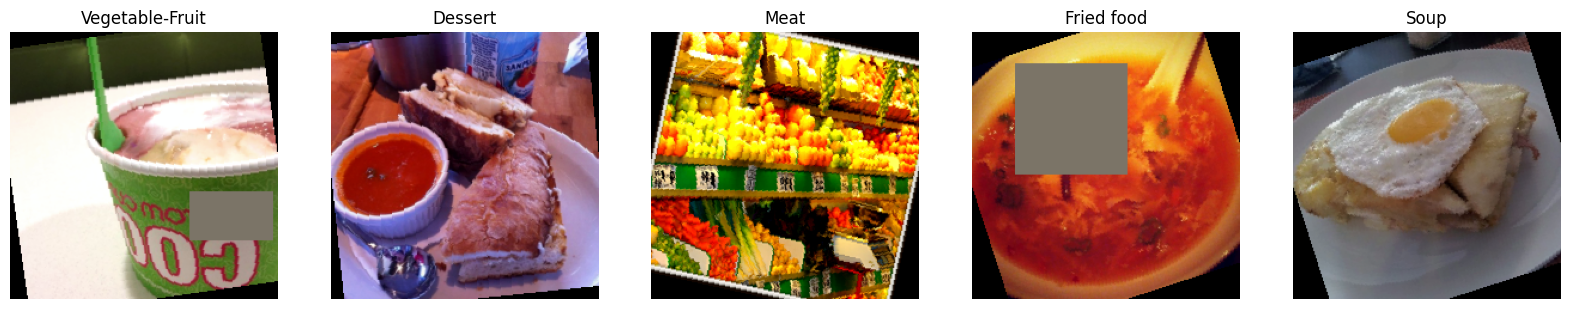

Analyzing validation set
                 count
Dessert            500
Dairy product      144
Vegetable-Fruit    232
Soup               500
Seafood            347
Bread              362
Rice                96
Egg                327
Noodles-Pasta      147
Fried food         326
Meat               449
            count
count   11.000000
mean   311.818182
std    142.164565
min     96.000000
25%    189.500000
50%    327.000000
75%    405.500000
max    500.000000


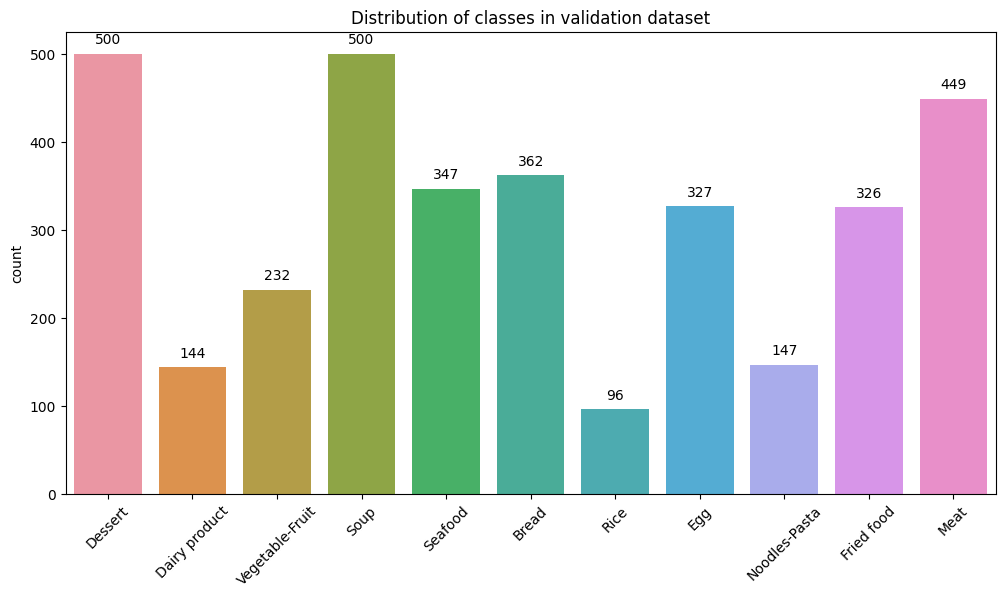

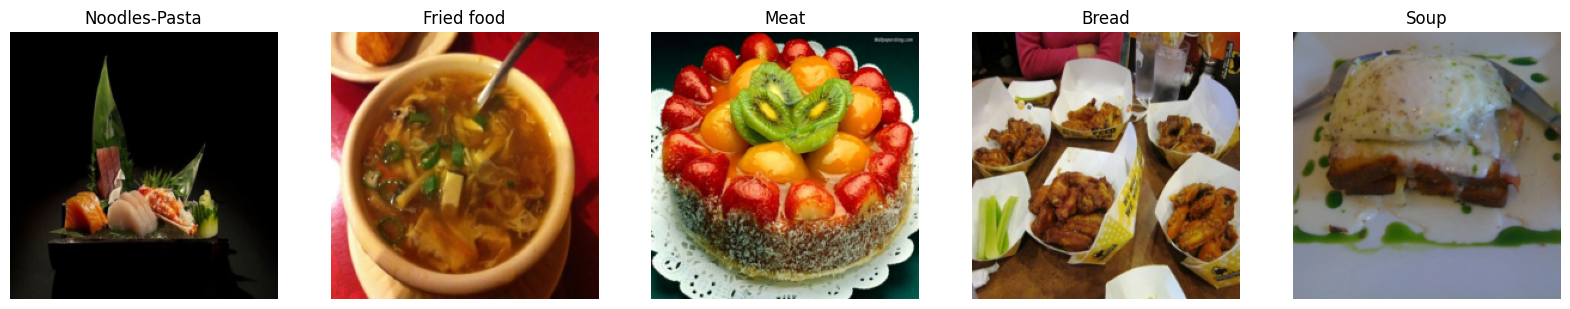

Analyzing evaluation set
                 count
Dessert            500
Dairy product      148
Vegetable-Fruit    231
Soup               500
Seafood            303
Bread              368
Rice                96
Egg                335
Noodles-Pasta      147
Fried food         287
Meat               432
            count
count   11.000000
mean   304.272727
std    140.050056
min     96.000000
25%    189.500000
50%    303.000000
75%    400.000000
max    500.000000


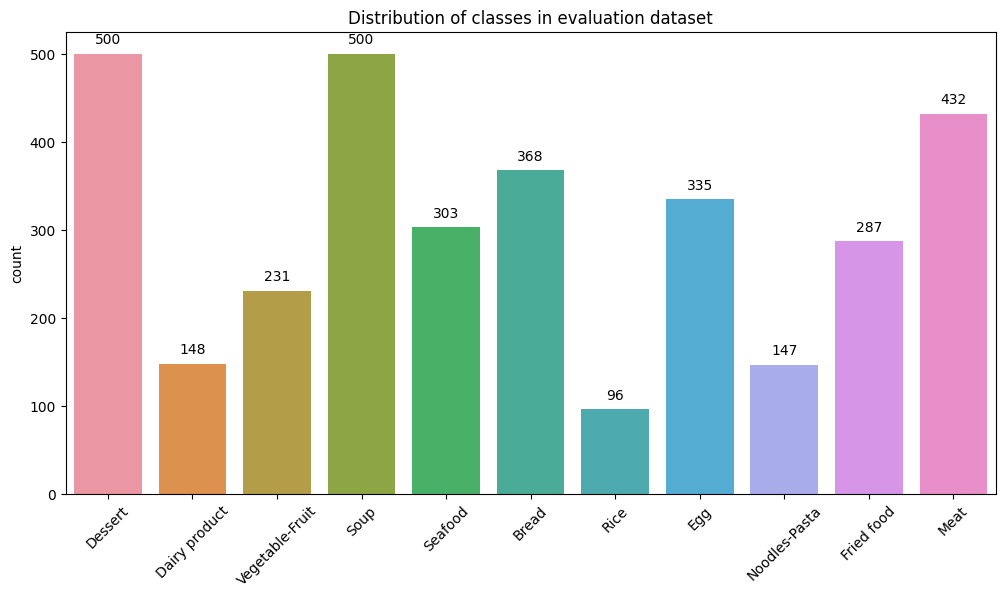

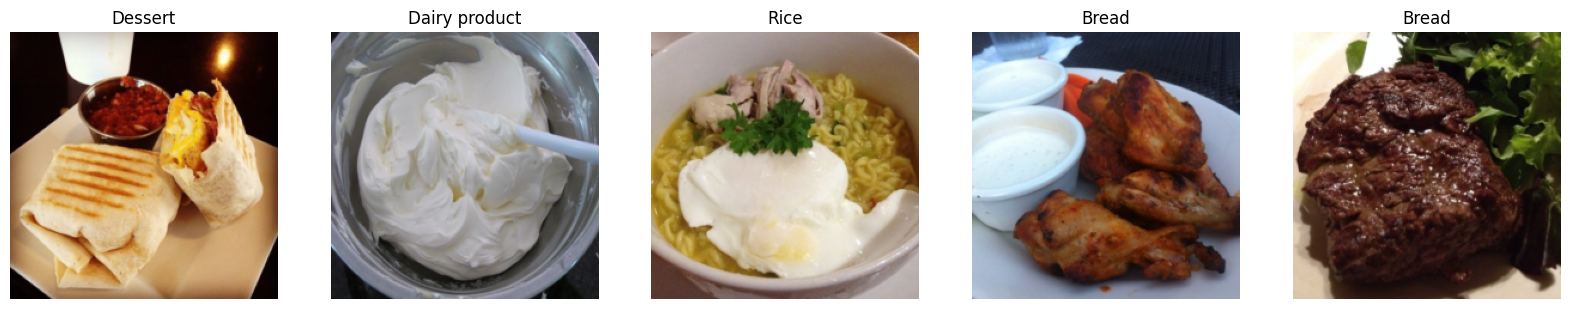

In [6]:
# Display an image and a title on top of it
def imshow(image, title):
    """Imshow for Tensor."""
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Turn off axis

# Define the sets
sets = ['training', 'validation', 'evaluation']

# Define the loaders
loaders = [train_loader, valid_loader, test_loader]

# Loop over each set
for set_name, loader in zip(sets, loaders):
    print(f"Analyzing {set_name} set")

    # Assuming the labels are the names of the folders
    labels = os.listdir(f"./food11-image-dataset/{set_name}")

    # Count the number of images in each category
    counts = {}
    for label in labels:
        counts[label] = len(os.listdir(f"./food11-image-dataset/{set_name}/{label}"))

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])

    # Display the DataFrame
    print(df)

    # Display statistical summary
    print(df.describe())

    # Plot a bar chart
    plt.figure(figsize=(12,6))
    barplot = sns.barplot(data=df, x=df.index, y='count')
    plt.title(f'Distribution of classes in {set_name} dataset')
    plt.xticks(rotation=45)  # Rotate the x-axis labels

    # Add count on top of each bar
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')

    plt.show()

    # Get a batch of data
    inputs, classes = next(iter(loader))

    # Display each image with its label
    plt.figure(figsize=(20,20))  # Increase the size of the figure
    for i in range(5):
        plt.subplot(1, 5, i+1)
        imshow(inputs[i], title=labels[classes[i]])
    plt.show()

## <b>5. Evaluating Deep Learning Algorithms:</b>

In [7]:
# Declaring the value of EPOCS and counter for tracking number of epochs without improvement
n_epochs = 15
no_improve_counter_limit = 3

### <b>a. RESNET-34:</b>

In [8]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet34 model
model = torchvision.models.resnet34(weights=torchvision.models.resnet.ResNet34_Weights.IMAGENET1K_V1)

# Replace the final layer to match the number of classes in the dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 11)

# Move the model to the GPU if available
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 137MB/s] 


In [9]:
# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [10]:
# Declaration of lists for storing loss and accuracy
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

# Initialize best_acc for accuracy tracking
best_acc = 0.0

# Counter for tracking number of epochs without improvement
no_improve_counter = 0

# Train the model
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # tqdm is used to display the progress bar
    with tqdm(total=len(train_loader)) as pbar:
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
                
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
                
            pbar.update(1)

    # Calculate the average loss and accuracy on the training set            
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    # Validation    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient computation
    with torch.no_grad():
        # tqdm is used to display the progress bar
        with tqdm(total=len(valid_loader)) as pbar:
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                    
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                    
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()                   
                pbar.update(1)

    # Calculate the average loss and accuracy on the validation set            
    val_loss = running_loss / len(valid_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)
        
    # Save the model checkpoint if it has the best accuracy so far
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.ckpt')
        no_improve_counter = 0  # reset counter when there is improvement
    else:
        no_improve_counter += 1  # increment counter when there is no improvement

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # If validation accuracy doesn't improve for 3 epochs, stop training
    if no_improve_counter >= no_improve_counter_limit:
        print("Validation accuracy didn't improve for 3 epochs, stopping...")
        break

# Print the best validation accuracy
print(f'Best validation accuracy: {best_acc:.4f}')

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1/15, Train Loss: 1.0259, Train Acc: 66.9370, Val Loss: 0.5179, Val Acc: 83.7901


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2/15, Train Loss: 0.5139, Train Acc: 83.1847, Val Loss: 0.4148, Val Acc: 86.4723


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3/15, Train Loss: 0.4064, Train Acc: 86.5194, Val Loss: 0.3553, Val Acc: 88.3965


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4/15, Train Loss: 0.3347, Train Acc: 88.9013, Val Loss: 0.3598, Val Acc: 89.2711


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5/15, Train Loss: 0.2859, Train Acc: 90.4217, Val Loss: 0.3343, Val Acc: 89.4752


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6/15, Train Loss: 0.2367, Train Acc: 92.3677, Val Loss: 0.3412, Val Acc: 89.4461


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7/15, Train Loss: 0.2080, Train Acc: 93.2901, Val Loss: 0.3395, Val Acc: 89.7376


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 8/15, Train Loss: 0.1819, Train Acc: 94.1314, Val Loss: 0.3211, Val Acc: 90.3499


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 9/15, Train Loss: 0.1632, Train Acc: 94.7496, Val Loss: 0.3106, Val Acc: 90.9038


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 10/15, Train Loss: 0.1583, Train Acc: 94.8409, Val Loss: 0.3253, Val Acc: 89.8834


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 11/15, Train Loss: 0.1391, Train Acc: 95.6315, Val Loss: 0.3193, Val Acc: 91.0787


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 12/15, Train Loss: 0.1238, Train Acc: 95.9761, Val Loss: 0.3157, Val Acc: 90.9913


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 13/15, Train Loss: 0.1197, Train Acc: 96.0268, Val Loss: 0.3460, Val Acc: 90.8455


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 14/15, Train Loss: 0.1092, Train Acc: 96.4221, Val Loss: 0.3510, Val Acc: 90.3207
Validation accuracy didn't improve for 3 epochs, stopping...
Best validation accuracy: 91.0787


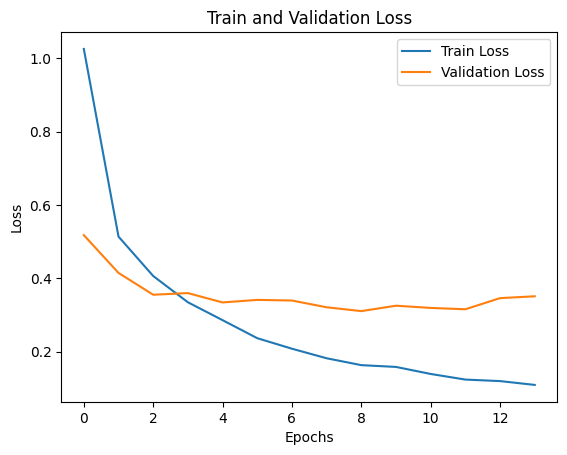

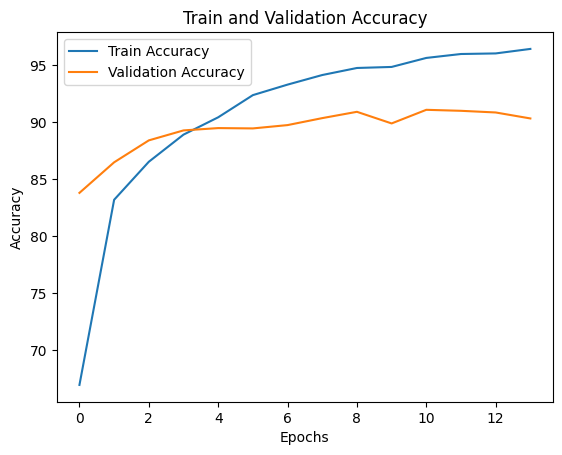

In [16]:
# Plotting the loss curves
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [17]:
# load best model weights
model.load_state_dict(torch.load('best_model.ckpt'))

# The model is in eval mode.
model.eval()

# These are used to record information in testing.
test_accs = []
all_labels = []
all_preds = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # Using torch.no_grad() to accelerate the forward process.
    with torch.no_grad():
        logits = model(imgs)

    # Compute the loss.
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

    # Record labels and predictions for confusion matrix
    all_labels.extend(labels.tolist())
    all_preds.extend(logits.argmax(dim=-1).tolist())

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy: {test_acc}')

# Compute precision, recall, F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the evaluation metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Compute AUC-ROC for each class
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
all_preds_bin = label_binarize(all_preds, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
auc_roc = roc_auc_score(all_labels_bin, all_preds_bin, average='weighted', multi_class='ovr')

# Print AUC-ROC
print(f'AUC-ROC: {auc_roc}')

  0%|          | 0/105 [00:00<?, ?it/s]

Test accuracy: 0.9268797039985657
Precision: 0.9268901245353004
Recall: 0.926800119510009
F1 Score: 0.9266273471019627
AUC-ROC: 0.9587950755447372


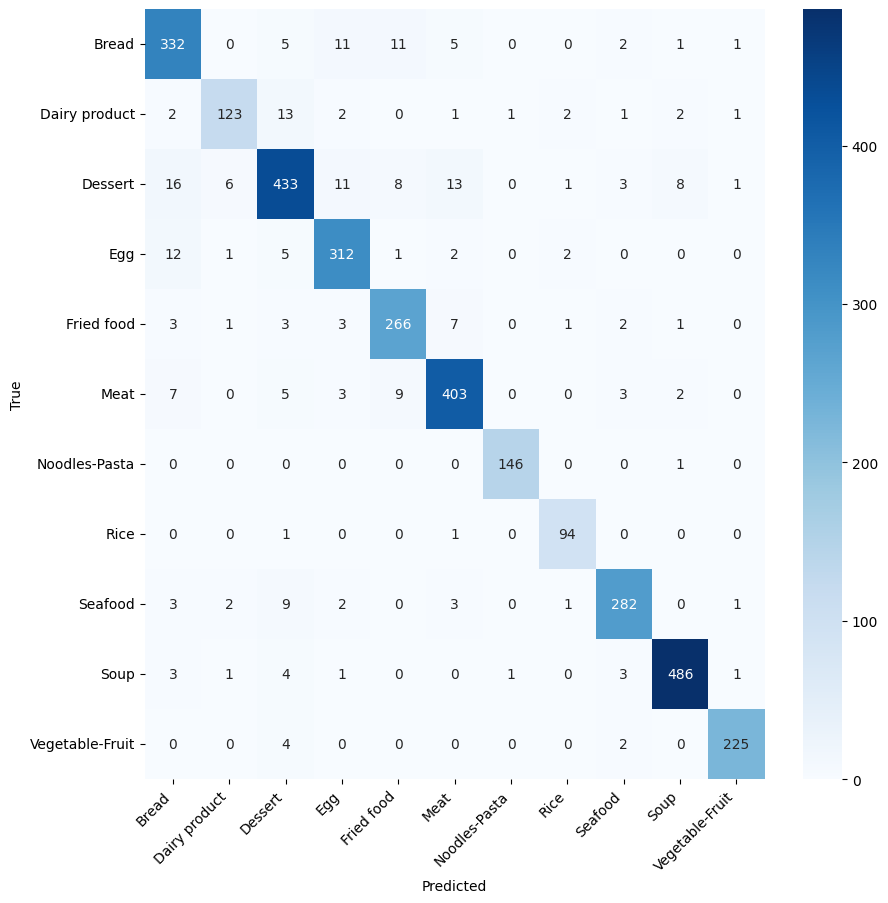

In [18]:
# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Convert label numbers to class names
class_names = test_loader.dataset.classes

# Plot heatmap
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')

# Adjust label positions
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')
plt.show()

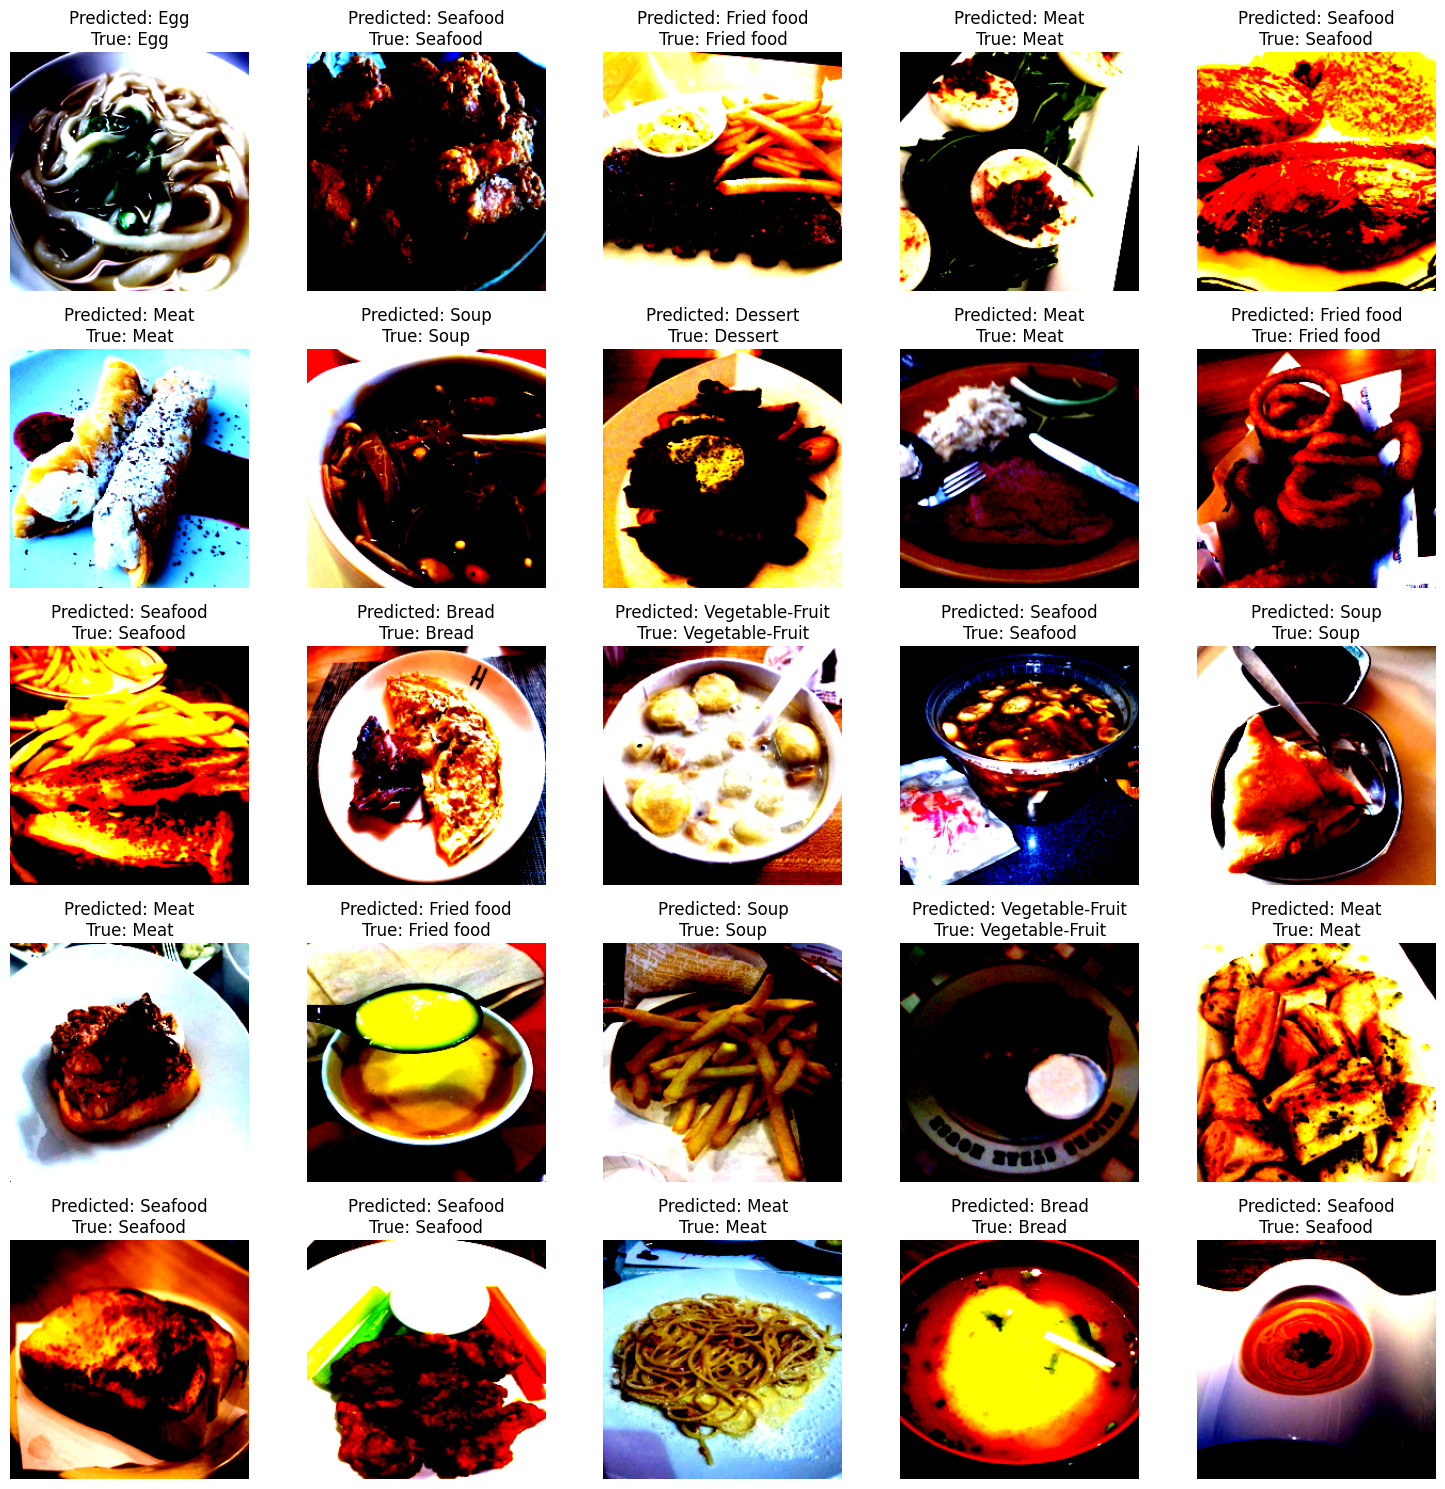

In [19]:
# Define the number of rows and columns for the subplot grid
rows = int(np.sqrt(batch_size))
cols = int(np.sqrt(batch_size))

# Get the class names from the dataset
class_names = test_loader.dataset.classes

# Get a batch of test data
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

# Make predictions
outputs = model(inputs)
_, predicted = outputs.max(1)

# Record labels and predictions for confusion matrix
all_labels.extend(labels.tolist())
all_preds.extend(predicted.tolist())

# Move the inputs and predictions to CPU for visualization
inputs = inputs.cpu()
predicted = torch.tensor(all_preds).cpu()

# Plot the images and their predicted labels
fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.imshow(inputs[i].permute(1, 2, 0).numpy())
    ax.title.set_text(f'Predicted: {class_names[predicted[i]]}\nTrue: {class_names[all_labels[i]]}')
    ax.axis('off')  # Hide the axes
plt.tight_layout()
plt.show()

### <b>b. Densenet121:</b>

In [20]:
# Check if GPU is available. If not, use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pretrained DenseNet model using the new API
model = torchvision.models.densenet121(pretrained=True)

# Replace the final layer to match the number of classes in your dataset
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 11)

# Move the model to the GPU if available
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 128MB/s] 


In [21]:
# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [22]:
# Initialize the best accuracy
best_acc = 0.0

# Initialize counter for tracking number of epochs without improvement
no_improve_counter = 0

# Initialize lists to save the losses and accuracies
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

# Train the model on the training data
for epoch in range(n_epochs):
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            dataloader = train_loader
            model.train()  # Set model to training mode
        else:
            dataloader = valid_loader
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        # calculate average loss and accuracy
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        # copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            no_improve_counter = 0  # reset counter when there is improvement
        elif phase == 'val':
            no_improve_counter += 1  # increment counter when there is no improvement

        # At the end of each epoch, save the losses and accuracies
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracy.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracy.append(epoch_acc)
    
    # Print the loss and accuracy for each epoch
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy[-1]:.4f}')

    # If validation accuracy doesn't improve for 3 epochs, stop training
    if no_improve_counter >= no_improve_counter_limit:
        print("Validation accuracy didn't improve for 3 epochs, stopping...")
        break

# Print that training is complete
print('Training complete')

# load best model weights
model.load_state_dict(best_model_wts)

# Save the best model
torch.save(model.state_dict(), 'best_model.pth')

# Print the best validation accuracy
print(f'Best validation accuracy: {best_acc:.4f}')

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1/15, Train Loss: 1.0012, Train Acc: 0.6848, Val Loss: 0.4891, Val Acc: 0.8487


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2/15, Train Loss: 0.4749, Train Acc: 0.8456, Val Loss: 0.3694, Val Acc: 0.8860


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3/15, Train Loss: 0.3694, Train Acc: 0.8786, Val Loss: 0.3232, Val Acc: 0.8991


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4/15, Train Loss: 0.3041, Train Acc: 0.9042, Val Loss: 0.2861, Val Acc: 0.9137


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5/15, Train Loss: 0.2651, Train Acc: 0.9140, Val Loss: 0.2879, Val Acc: 0.9087


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6/15, Train Loss: 0.2225, Train Acc: 0.9278, Val Loss: 0.2823, Val Acc: 0.9134


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7/15, Train Loss: 0.1937, Train Acc: 0.9394, Val Loss: 0.2833, Val Acc: 0.9128
Validation accuracy didn't improve for 3 epochs, stopping...
Training complete
Best validation accuracy: 0.9137


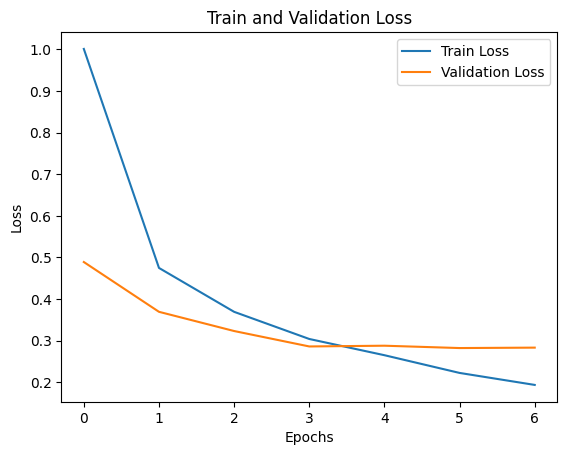

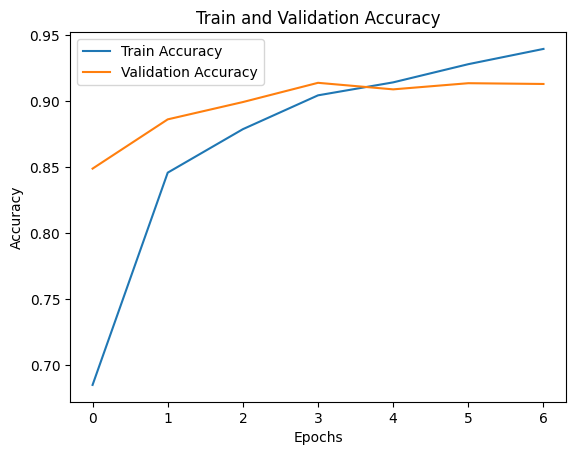

In [29]:
# Plotting the loss curves
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot([acc.cpu().numpy() for acc in train_accuracy], label='Train Accuracy')
plt.plot([acc.cpu().numpy() for acc in val_accuracy], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [30]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
model.eval()

# These are used to record information in testing.
test_accs = []
all_labels = []
all_preds = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)
    
    # Using torch.no_grad() to accelerate the forward process.
    with torch.no_grad():
        logits = model(imgs)
    
    # Calculate the loss.
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

    # Record labels and predictions for confusion matrix
    all_labels.extend(labels.tolist())
    all_preds.extend(logits.argmax(dim=-1).tolist())

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy: {test_acc}')

# Compute precision, recall, F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the evaluation metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Compute AUC-ROC for each class
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
all_preds_bin = label_binarize(all_preds, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
auc_roc = roc_auc_score(all_labels_bin, all_preds_bin, average='weighted', multi_class='ovr')

# Print AUC-ROC
print(f'AUC-ROC: {auc_roc}')

  0%|          | 0/105 [00:00<?, ?it/s]

Test accuracy: 0.9307487607002258
Precision: 0.9310349055377151
Recall: 0.9306841948013146
F1 Score: 0.9306653174858137
AUC-ROC: 0.9611805992632855


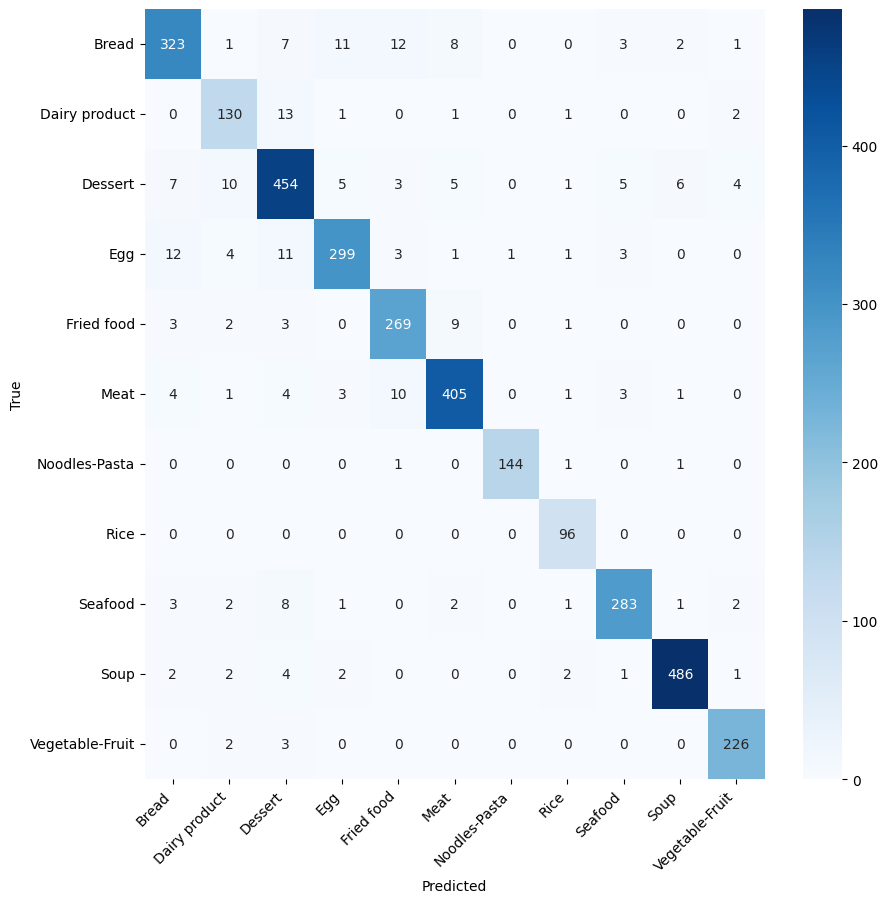

In [31]:
# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Convert label numbers to class names
class_names = test_loader.dataset.classes

# Plot heatmap
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')

# Adjust label positions
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')
plt.show()

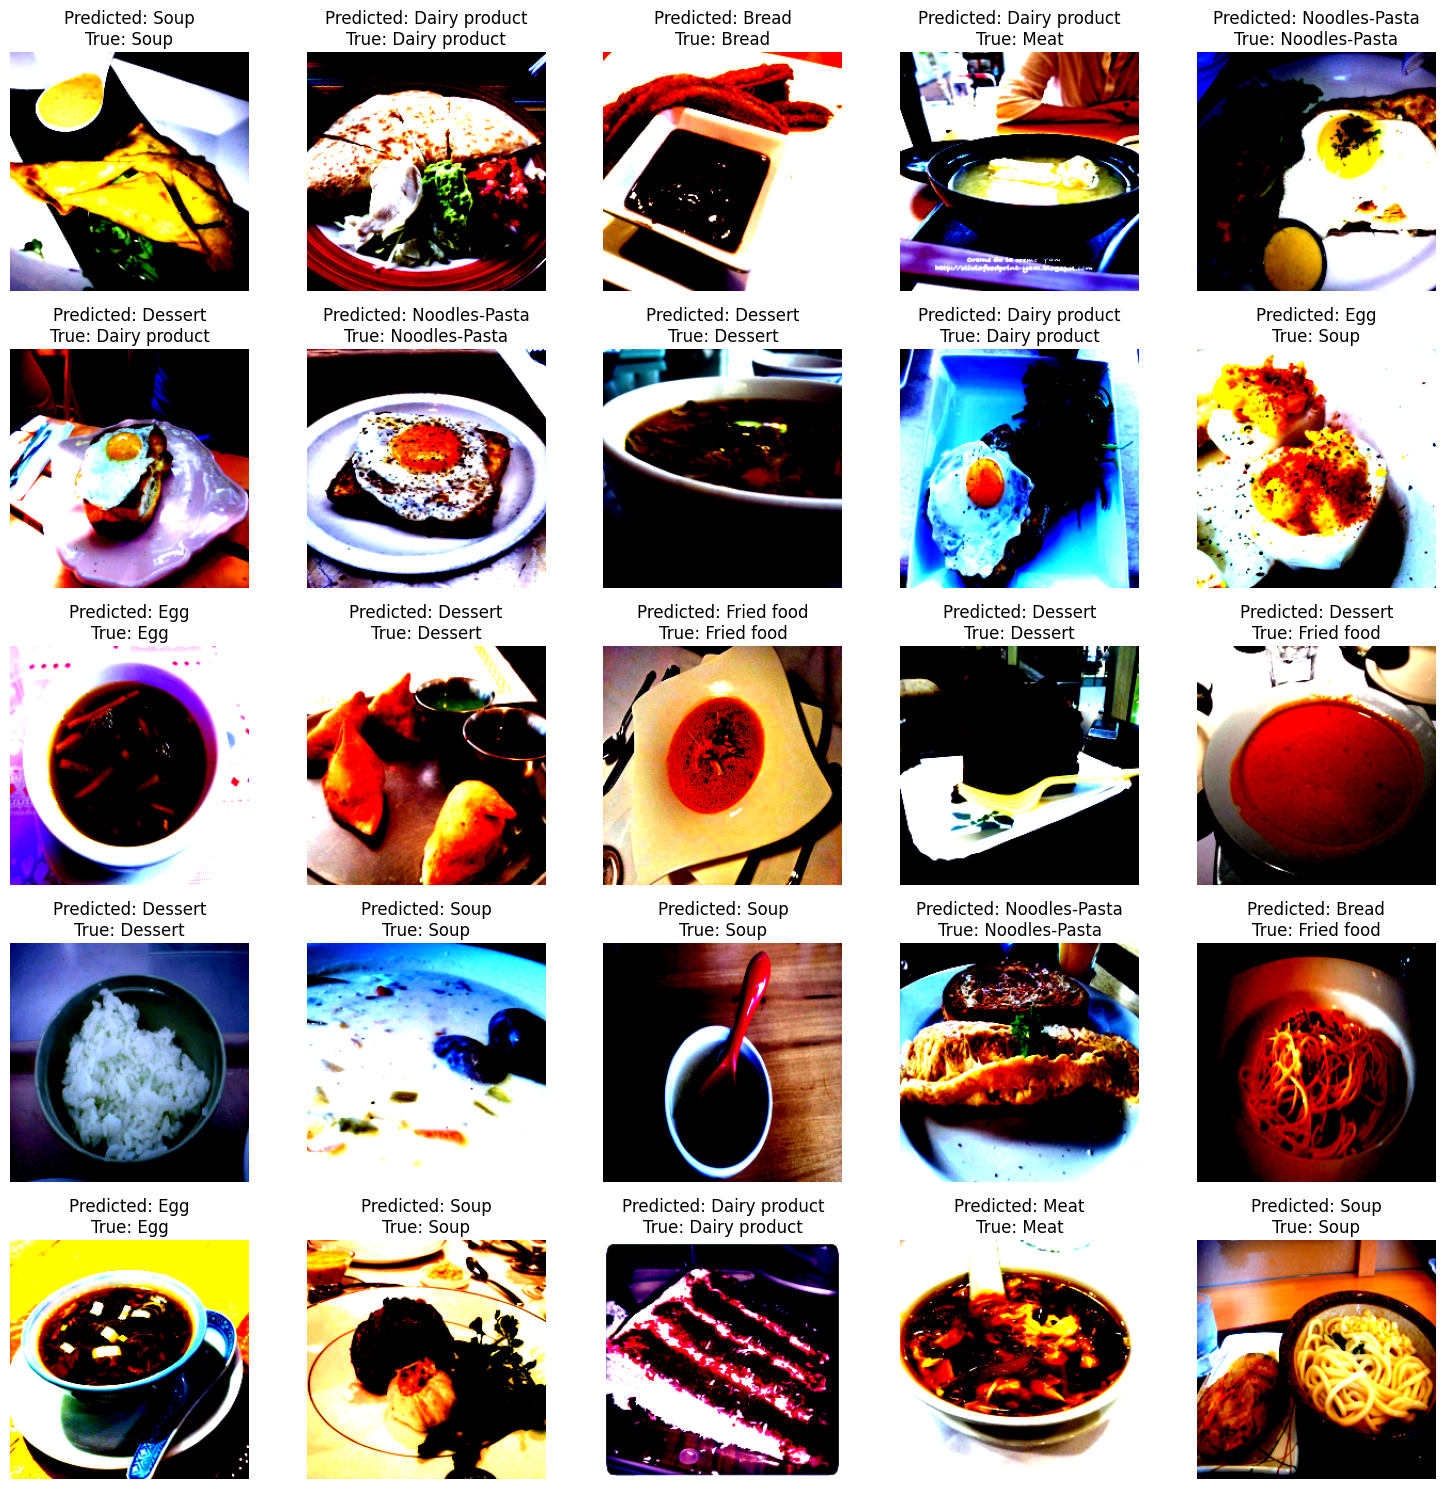

In [32]:
# Define the number of rows and columns for the subplot grid
rows = int(np.sqrt(batch_size))
cols = int(np.sqrt(batch_size))

# Get the class names from the dataset
class_names = test_loader.dataset.classes

# Get a batch of test data
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

# Make predictions
outputs = model(inputs)
_, predicted = outputs.max(1)

# Record labels and predictions for confusion matrix
all_labels.extend(labels.tolist())
all_preds.extend(predicted.tolist())

# Move the inputs and predictions to CPU for visualization
inputs = inputs.cpu()
predicted = torch.tensor(all_preds).cpu()

# Plot the images and their predicted labels
fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.imshow(inputs[i].permute(1, 2, 0).numpy())
    ax.title.set_text(f'Predicted: {class_names[predicted[i]]}\nTrue: {class_names[all_labels[i]]}')
    ax.axis('off')  # Hide the axes
plt.tight_layout()
plt.show()

### <b>c. VGG-16:</b>

In [33]:
# Load the pre-trained VGG model
model = models.vgg16(pretrained=True)

# Load the pre-trained VGG model
model = models.vgg16(pretrained=True)

num_classes = 11  # Replace with your number of classes

# Replace the final fully-connected layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 163MB/s]  


In [34]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [35]:
# Initialize lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

# Initialize best_acc for accuracy tracking
best_acc = 0.0

# Initialize counter for tracking number of epochs without improvement
no_improve_counter = 0

# Train the model
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # tqdm is used to display the progress bar
    with tqdm(total=len(train_loader)) as pbar:
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.update(1)

    # Calculate the average loss and accuracy on the training set        
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    
    # Switch to evaluation mode
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient computation
    with torch.no_grad():
        with tqdm(total=len(valid_loader)) as pbar:
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.update(1)

    # Calculate the average loss and accuracy on the validation set        
    val_loss = running_loss / len(valid_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    
    # Save the model checkpoint if it has the best accuracy so far
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.ckpt')
        no_improve_counter = 0  # reset counter when there is improvement
    else:
        no_improve_counter += 1  # increment counter when there is no improvement
    
    # Print the information for each epoch
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # If validation accuracy doesn't improve for 3 epochs, stop training
    if no_improve_counter >= no_improve_counter_limit:
        print("Validation accuracy didn't improve for 3 epochs, stopping...")
        break

# Print the best validation accuracy
print(f'Best validation accuracy: {best_acc:.4f}')

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1/15, Train Loss: 0.9386, Train Acc: 68.9844, Val Loss: 0.6210, Val Acc: 79.5335


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2/15, Train Loss: 0.5765, Train Acc: 80.9852, Val Loss: 0.4759, Val Acc: 84.0525


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3/15, Train Loss: 0.4635, Train Acc: 84.5733, Val Loss: 0.4425, Val Acc: 85.1020


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4/15, Train Loss: 0.3976, Train Acc: 86.9045, Val Loss: 0.3997, Val Acc: 87.4927


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5/15, Train Loss: 0.3489, Train Acc: 88.5972, Val Loss: 0.3507, Val Acc: 89.1254


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6/15, Train Loss: 0.3189, Train Acc: 89.4993, Val Loss: 0.3973, Val Acc: 87.4052


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7/15, Train Loss: 0.2678, Train Acc: 91.1312, Val Loss: 0.3406, Val Acc: 89.6793


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 8/15, Train Loss: 0.2360, Train Acc: 91.9116, Val Loss: 0.3570, Val Acc: 88.7172


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 9/15, Train Loss: 0.2266, Train Acc: 92.2461, Val Loss: 0.3602, Val Acc: 89.4169


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 10/15, Train Loss: 0.2024, Train Acc: 93.4219, Val Loss: 0.3777, Val Acc: 88.4548
Validation accuracy didn't improve for 3 epochs, stopping...
Best validation accuracy: 89.6793


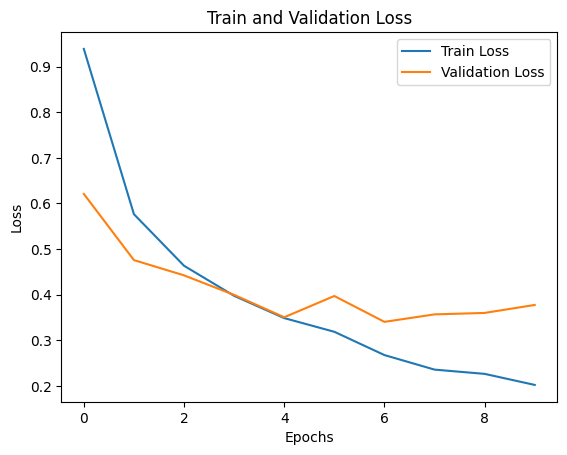

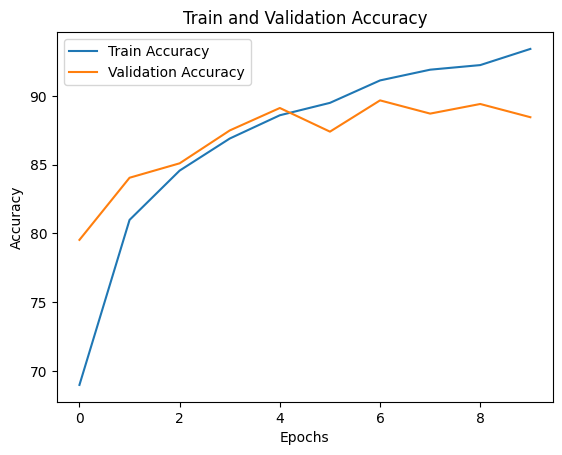

In [36]:
# Plotting the loss curves
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [37]:
# load best model weights
model.load_state_dict(torch.load('best_model.ckpt'))

# Make sure the model is in eval mode.
model.eval()

# These are used to record information in testing.
test_accs = []
all_labels = []
all_preds = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # Using torch.no_grad() to accelerate the forward process.
    with torch.no_grad():
        logits = model(imgs)
    
    # Calculate the loss.
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

    # Record labels and predictions for confusion matrix
    all_labels.extend(labels.tolist())
    all_preds.extend(logits.argmax(dim=-1).tolist())

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy: {test_acc}')

# Compute precision, recall, F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the evaluation metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Compute AUC-ROC for each class
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
all_preds_bin = label_binarize(all_preds, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
auc_roc = roc_auc_score(all_labels_bin, all_preds_bin, average='weighted', multi_class='ovr')

# Print AUC-ROC
print(f'AUC-ROC: {auc_roc}')

  0%|          | 0/105 [00:00<?, ?it/s]

Test accuracy: 0.9194391965866089
Precision: 0.9206380816530407
Recall: 0.9193307439498059
F1 Score: 0.9191392680727426
AUC-ROC: 0.9545256657773212


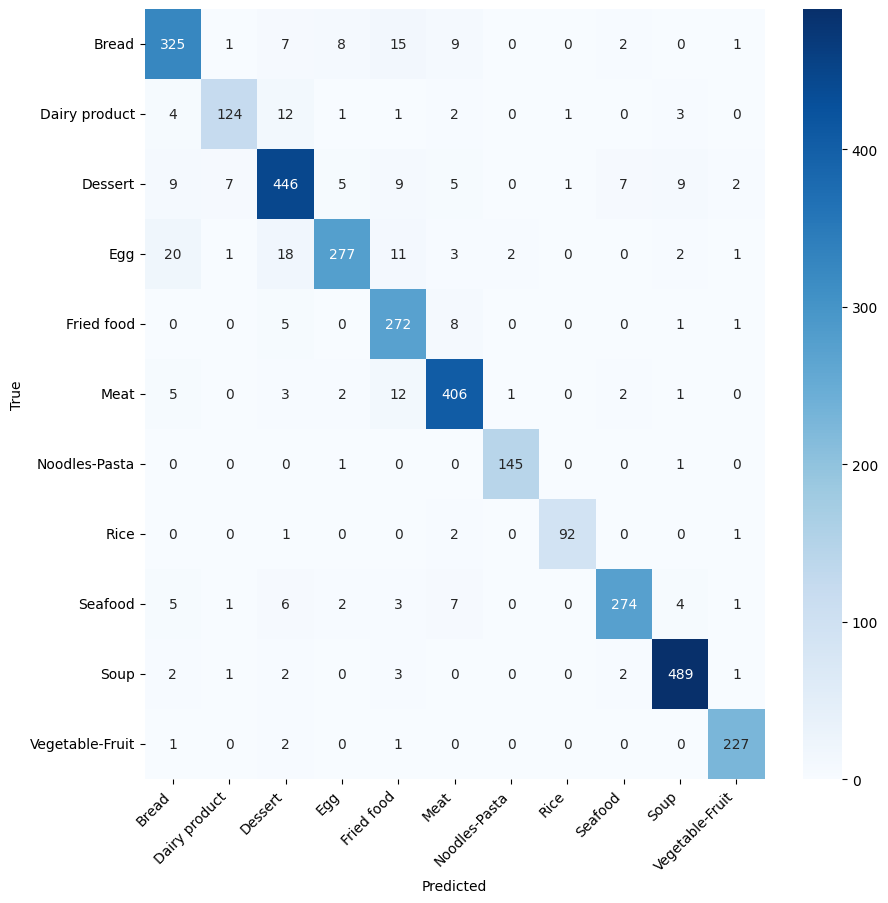

In [38]:
# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Convert label numbers to class names
class_names = test_loader.dataset.classes

# Plot heatmap
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')

# Adjust label positions
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')
plt.show()

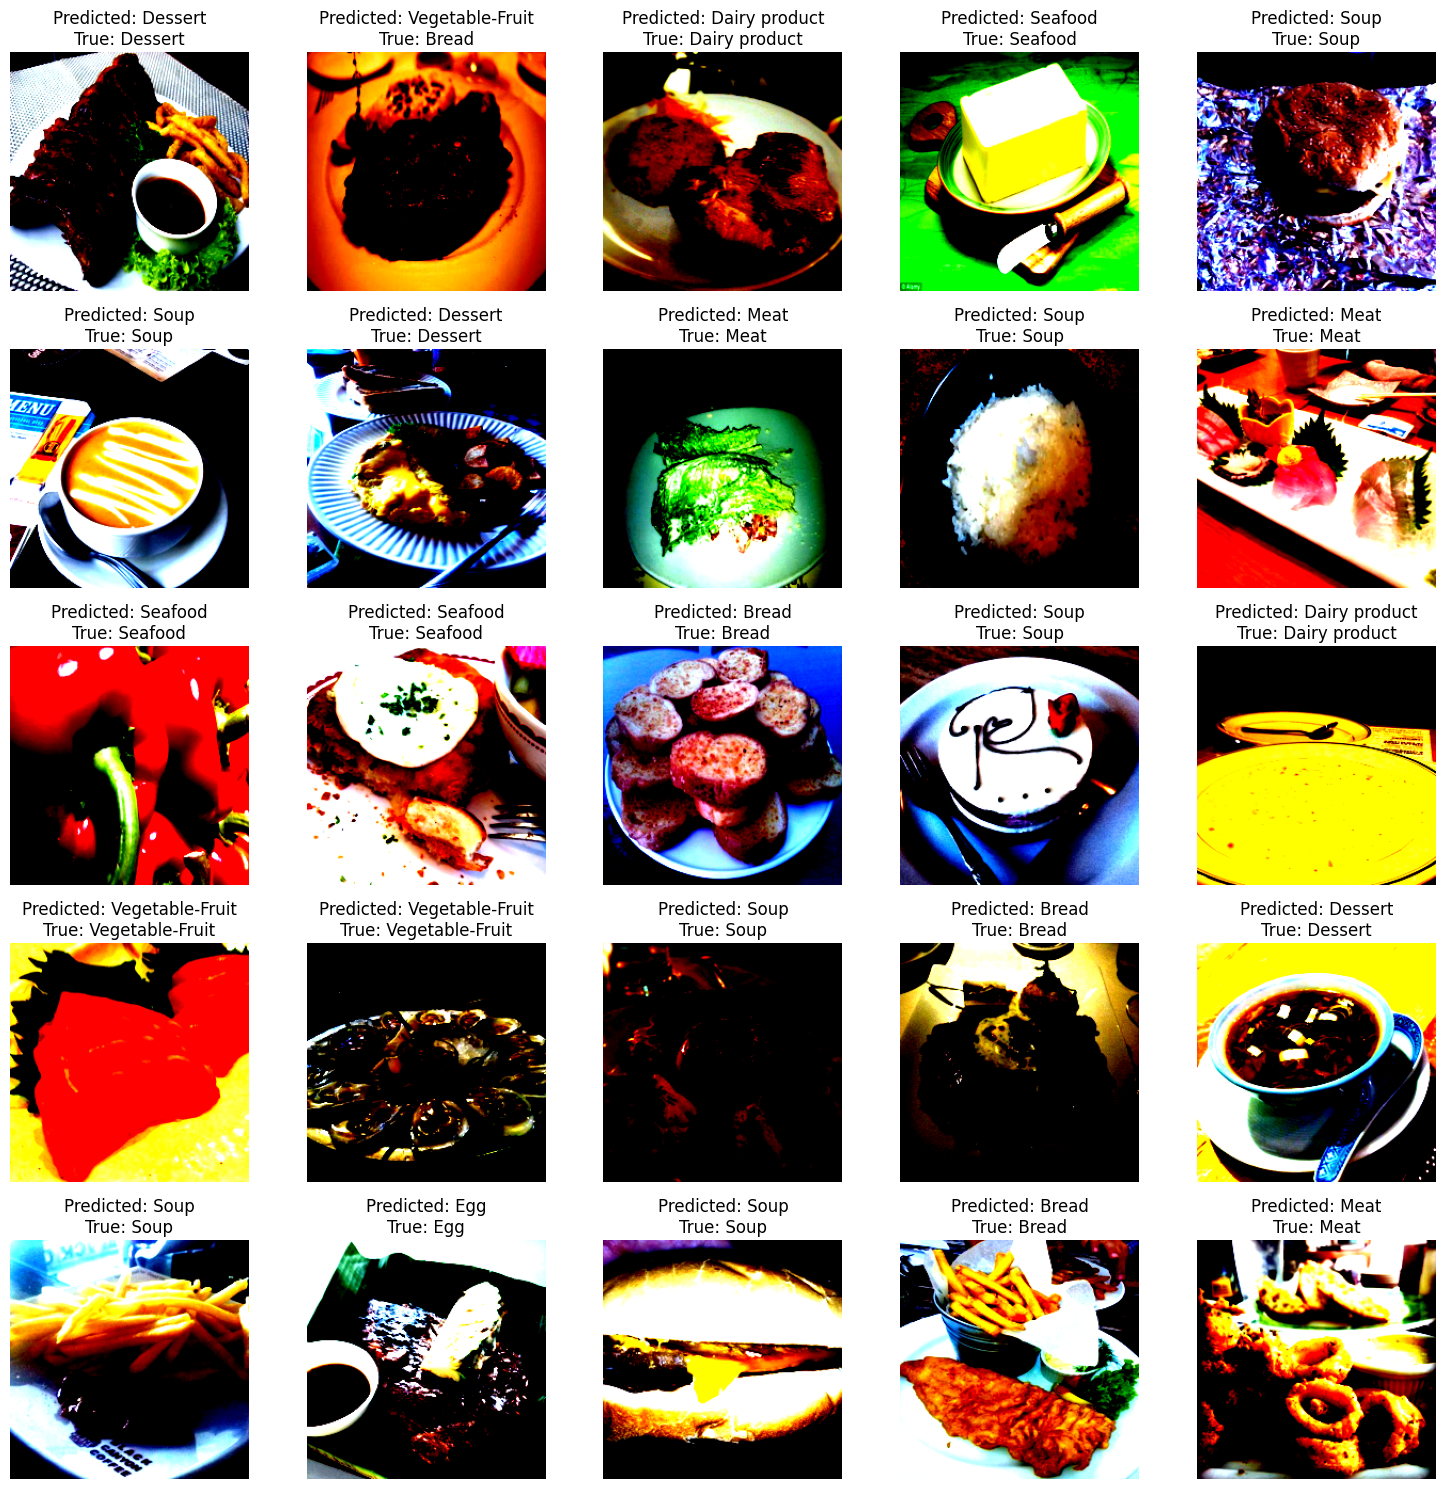

In [39]:
# Define the number of rows and columns for the subplot grid
rows = int(np.sqrt(batch_size))
cols = int(np.sqrt(batch_size))

# Get the class names from the dataset
class_names = test_loader.dataset.classes

# Get a batch of test data
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

# Make predictions
outputs = model(inputs)
_, predicted = outputs.max(1)

# Record labels and predictions for confusion matrix
all_labels.extend(labels.tolist())
all_preds.extend(predicted.tolist())

# Move the inputs and predictions to CPU for visualization
inputs = inputs.cpu()
predicted = torch.tensor(all_preds).cpu()

# Plot the images and their predicted labels
fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.imshow(inputs[i].permute(1, 2, 0).numpy())
    ax.title.set_text(f'Predicted: {class_names[predicted[i]]}\nTrue: {class_names[all_labels[i]]}')
    ax.axis('off')  # Hide the axes
plt.tight_layout()
plt.show()